# Analysis of the resistome datasets from nanopore, Sanger and PacBio
The input data from this analysis comes from two sources: poreFUME for the nanoporeset and the ```calculateResistome.ipynb``` notebook for mainly the Sanger and PacBio dataset.

The output of this notebook consist of:
1. Frequency distribution of read lengths and incorporate the tapestation data from the porecamp set (library b)
2. Metric table with an overview of size distribution, yield etc. exported as csv and xlx
3. Barcode distribution from the demuxed files
4. Sequence identity of all the datasets against the Sanger data
5. Abundance of the CARD genes found in the nanopore and PacBio set
6. Correlation between the PacBio and nanopore set as measured by CARD annotations
7. Sequence identity of all the identified genes
8. Example of hit found grown on spectinomycin


We first load in the data files. Typically run using a poreFUME command
```!python poreFUME.py inputData/sample10.fasta inputData/pb_39b.fasta --PacBioLegacyBarcode --cores 4 --barcodeEdge 120``` and by running ```calculateResistome.ipynb```



 

In [ ]:
#This command runs poreFUME on both the 2D reads from library A (LejlaControl.2D.min500bp.fasta) and library B(poreCamp.2D.min500.fasta)
#Note that on 4 cores this process can take long. Mainly because the Smith-Waterman aligner for barode dectection is slow, nanocorrect is slow and the annotation on the raw dataset is slow (can be turned of by omitting --annotateAll, which will only take the 2nd error corrected file *.NC2.fasta file)
!python poreFUME/poreFUME.py inputFiles/LejlaControl.2D.min500bp.fasta poreFUME/inputData/pb_39b.fasta  --barcodeEdge=60 --pathNanocorrect={nanocorrectDir} --PacBioLegacyBarcode --cores 8 --pathCARD=inputData/n.fasta.protein.homolog.fasta --pathNanocorrect=---abspahgoeshere--/nanocorrect/ --pathRawreads=---abspahgoeshereToENAFiles- --overwriteNanocorrect --pathNanopolish=---abspahgoeshere--/nanopolish/ --overwriteNanopolish --overwriteDemux --overwriteCARD
!python poreFUME/poreFUME.py inputFiles/poreCamp.2D.min500.fasta poreFUME/inputData/pb_39b.fasta  --pathNanocorrect={nanocorrectDir}  --barcodeEdge=120 --PacBioLegacyBarcode --cores 8 --pathCARD=inputData/n.fasta.protein.homolog.fasta --pathNanocorrect=---abspahgoeshere--/nanocorrect/ --pathRawreads=---abspahgoeshereToENAFiles- --overwriteNanocorrect --pathNanopolish=---abspahgoeshere--/nanopolish/ --overwriteNanopolish --overwriteDemux --overwriteCARD

In [1]:
%matplotlib inline
from collections import OrderedDict
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt
import os
from Bio import SeqIO
from types import *
import numpy as np
import scipy.stats
import seaborn as sns

//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1011: UserWarning: Duplicate key in file "//anaconda/lib/python2.7/site-packages/matplotlib/mpl-data/stylelib/dark_background.mplstyle", line #9
  (fname, cnt))
:0: FutureWarning: IPython widgets are experimental and may change in the future.


### Load in data
Before running this notebook ```calculateResistome.ipynb``` should be ran, as this notebook ```analyzeResistome.ipynb``` will use the results generated. 
The paths to the used datafiles is hardcoded in ```paths.py```. In principle these paths can be generated dynamically but for the sake of tracablility they are harcoded.
General conventions:
```S_``` refers to the Sanger dataset. Where ```_raw``` are the trimmed (using CLC, so not in a notebook) and >500bp but unassembled Sanger reads.
```PB_``` refers to the PacBio dataset. ```_raw``` are the demuxed and quality selected reads (using SMRT portal) from two sequencing cells. ```_ass``` are collapsed reads using pbdagcon. ```MI_``` is the library A and ```MIpc_``` is library B. 


In [70]:
# %load paths.py
qPathOrdered = OrderedDict([
        
    ('S_raw','inputFiles/sanger.total.aftertrim.removeCT.min500bp.fasta'),
    ('S_ass','inputFiles/SangerAssembledAndNonAssembled.min500bp.withoutCandT.fasta'),


    ('PB_raw','inputFiles/PB.Cell1and2.raw.fasta'),
    ('PB_ass','inputFiles/PacBio.Correct.C1.fasta'),

    ('MI_raw','inputFiles/LejlaControl.2D.min500bp.fasta'),
    ('MI_demux'   , 'output/LejlaControl.2D.min500bp.afterBC.fasta'),
    ('MI_corr1'   , 'output/LejlaControl.2D.min500bp.afterNC1.fasta'),
    ('MI_corr2'   , 'output/LejlaControl.2D.min500bp.afterNC2.fasta'), 
    ('MI_polish'   , 'output/LejlaControl.2D.min500bp.afterNP.fasta'),
    ('MI_polishNoFilter'   , 'output/LejlaControl.2D.min500bp.afterNPnofilter.fasta'), #This file will be generated by calculateResistome.ipynb


    ('MIpc_raw', 'inputFiles/poreCamp.2D.min500.fasta'), 
    ('MIpc_demux' , 'output/poreCamp.2D.min500.afterBC.fasta'),  
    ('MIpc_corr1' , 'output/poreCamp.2D.min500.afterNC1.fasta'), 
    ('MIpc_corr2' , 'output/poreCamp.2D.min500.afterNC2.fasta'),
    #('MIpc_polish'   , 'output/poreCamp.2D.min500.afterNP.fasta'),
    #('MIpc_polishNoFilter'   , 'output/poreCamp.2D.min500.afterNPnofilter.fasta') #This file will be generated by calculateResistome.ipynb

        
      
    
    ])

annotationPathOrdered = OrderedDict([
        
    ('S_raw','output/annotation/sanger.total.aftertrim.removeCT.min500bp.fasta.annotated.csv'), 
    ('S_ass','output/annotation/SangerAssembledAndNonAssembled.min500bp.withoutCandT.fasta.annotated.csv'),


    ('PB_raw','output/annotation/PB.Cell1and2.raw.fasta.annotated.csv'), 
    ('PB_ass','output/annotation/PacBio.Correct.C1.fasta.annotated.csv'),

    ('MI_raw','output/annotation/LejlaControl.2D.min500bp/LejlaControl.2D.min500bp.annotated.csv'), 
    ('MI_demux'   , 'output/annotation/LejlaControl.2D.min500bp/LejlaControl.2D.min500bp.afterBC.annotated.csv'), 
    ('MI_corr1'   , 'output/annotation/LejlaControl.2D.min500bp/LejlaControl.2D.min500bp.afterNC1.annotated.csv'), 
    ('MI_corr2'   , 'output/annotation/LejlaControl.2D.min500bp/LejlaControl.2D.min500bp.afterNC2.annotated.csv'), 
    ('MI_polishNoFilter'   , 'output/annotation/LejlaControl.2D.min500bp.afterNPnofilter.fasta.annotated.csv'), 


    ('MIpc_raw', 'output/annotation/poreCamp.2D.min500/poreCamp.2D.min500.annotated.csv'), 
    ('MIpc_demux' , 'output/annotation/poreCamp.2D.min500/poreCamp.2D.min500.afterBC.annotated.csv'),  
    ('MIpc_corr1' , 'output/annotation/poreCamp.2D.min500/poreCamp.2D.min500.afterNC1.annotated.csv'),  
    ('MIpc_corr2' , 'output/annotation/poreCamp.2D.min500/poreCamp.2D.min500.afterNC2.annotated.csv'), 
    #('MIpc_polishNoFilter'   , 'output/annotation/poreCamp.2D.min500.afterNPnofilter.fasta.annotated.csv'), 
    

    
    ])


readLabels = OrderedDict([
        
    ('S_raw','Sanger raw'),
    ('S_ass','Sanger assembled'),


    ('PB_raw','PacBio raw'), 
    ('PB_ass','PacBio assembled'),


    ('MIpc_raw', 'nanopore lib. B:\n2D reads'), 
    ('MIpc_demux' , 'nanopore lib. B:\nafter debarcoding'),
    ('MIpc_corr1' , 'nanopore lib. B:\nafter nanocorrect round 1'), 
    ('MIpc_corr2' , 'nanopore lib. B:\nafter nanocorrect round 2'), 
    #('MIpc_polishNoFilter'   , 'nanopore lib. B:\nafter nanopolish')  ,

    ('MI_raw','nanopore lib. A: 2D reads'), 
    ('MI_demux'   , 'nanopore lib. A:\nafter debarcoding'),
    ('MI_corr1'   , 'nanopore lib. A:\nafter nanocorrect round 1'), 
    ('MI_corr2'   , 'nanopore lib. A:\nafter nanocorrect round 2')  ,
    ('MI_polishNoFilter'   , 'nanopore lib. A:\nafter nanopolish ')  

    
    ])

readLabelsSample = OrderedDict([
        
    ('S_raw','Sanger'), 
    ('S_ass','Sanger'),


    ('PB_raw','PacBio'), 
    ('PB_ass','PacBio'),


    ('MIpc_raw'   , 'nanopore lib. B'),
    ('MIpc_demux' , 'nanopore lib. B'), 
    ('MIpc_corr1' , 'nanopore lib. B'), 
    ('MIpc_corr2' , 'nanopore lib. B'), 
    #('MIpc_polishNoFilter'   , 'nanopore lib. B') ,
    
    ('MI_raw'     , 'nanopore lib. A'),
    ('MI_demux'   , 'nanopore lib. A'),
    ('MI_corr1'   , 'nanopore lib. A'), 
    ('MI_corr2'   , 'nanopore lib. A'),
    ('MI_polishNoFilter'   , 'nanopore lib. A') 

    
    ])

readLabelsWorkflow = OrderedDict([
        
    ('S_raw','raw'), 
    ('S_ass','assembled'),


    ('PB_raw','raw'), 
    ('PB_ass','assembled'),


    ('MIpc_raw', 'raw 2D'), 
    ('MIpc_demux' , 'after debarcoding'),
    ('MIpc_corr1' , 'after nanocorrect round 1'), 
    ('MIpc_corr2' , 'after nanocorrect round 2'),
    #('MIpc_polishNoFilter'   , 'after nanopolish')  ,

    ('MI_raw','raw 2D'), 
    ('MI_demux'   , 'after debarcoding'),
    ('MI_corr1'   , 'after nanocorrect round 1'), 
    ('MI_corr2'   , 'after nanocorrect round 2') ,
    ('MI_polishNoFilter'   , 'after nanopolish')  
    
    ])

pacbioMuxData = 'inputFiles/pacbioMux.p'


colorSet = {'MI': '#4daf4a',
        'PB': '#377eb8',
        'MIpc':'#ff7f00',
        'S':'#984ea3'}


# 1. Readlengths
Plot the readlengths for the various datasets. For the porecamp (library B) we also have tapestation data which can be overlayed

In [71]:
def getLengthDistribution(thisFilePath):
    """
    Return a list with containing the length of each fasta record
    Parameter:
    thisFilePath = path to fasta file
    
    """
    assert type(thisFilePath) is StringType, "thisFilePath is not a string: %r" % thisFilePath 
        
    #Test inputs
    if not os.path.isfile(thisFilePath):
        raise IOError('thisFilePath does not excist',thisFilePath)
        
        
    lenList = []
    for record in SeqIO.parse(thisFilePath, "fasta"): #REad in the raw porecamp reads (lib A)
        lenList.append(len(record)) #Store all the raw lengths in a list
    return lenList

porecamp2Dreads = getLengthDistribution(qPathOrdered['MIpc_raw'])

In [72]:
#Load in the tapestation results, they come from the .gDNA file and are manually translated into a csv file
porecampTapeStation = pd.read_csv('inputFiles/expData/20151215_porecamp_tapestation.csv',sep='\t',names=['size','RA']) #Load in the length distribution of Library B
porecampTapeStation = porecampTapeStation.set_index('size')

S_raw
Sanger raw
PB_raw
PacBio raw
MI_raw
nanopore lib. A: 2D reads


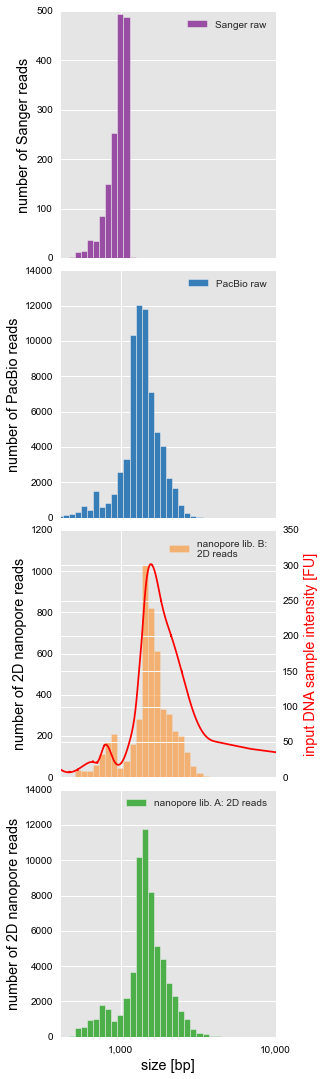

In [73]:
pp = PdfPages('figures/FigS01_LengthDistribution.v2.pdf')
sns.set(font_scale=1) 
plt.style.reload_library()
plt.style.use('ggplot_evdh')
def makeLengthPlot(thisRunName,ax,logSpaced=True):
    
    """
    Plot the length plot for the raw sequence data
    
    Parameters:
    
    thisRunName = Takes the name of the run ie. S_raw and looks up the path in qPathOrdered
    logSpaced = True, sets xaxis scale to log  by default
    """
    
    if logSpaced == True: #by defauld log-saced bins
        bins=np.logspace(0.1, 4, 100) #we are making log spaced bins!
    else:
        bins = range(500,3000,100)
    #fig, ax = plt.subplots()
    #ax.hist(getLengthDistribution(qPathOrdered[thisRunName]),bins=bins,color=colorSet[thisRunName.split('_')[0]],label=readLabels[thisRunName])
    sns.distplot(getLengthDistribution(qPathOrdered[thisRunName]),bins=bins, kde=False,color=colorSet[thisRunName.split('_')[0]], ax=ax,label=readLabels[thisRunName],hist_kws={"alpha": 1})
    #ax.set_xscale('log')
    #ax.set_xlabel('size [bp]')
    print thisRunName
    print readLabels[thisRunName]
    ax.legend()
    
    if thisRunName == 'S_raw':
        ax.set_ylabel('number of Sanger reads')
    elif thisRunName =='PB_raw':
        ax.set_ylabel('number of PacBio reads')
    else:
        ax.set_ylabel('number of 2D nanopore reads')

    if thisRunName == 'MI_raw':
        ax.set_ylim([0,14000]) #Fix the axis so the legend is not overlapping
        
    #ax.set_xlim([400,10000])
    if logSpaced == True:
        ax.set_xscale('log')
    ax.set_xlim([400,10000])
    ax.set_xticklabels(['99999','99999','1,000','10,000'])
    #fig.show()
    
    
fig, ax = plt.subplots(nrows=4,ncols=1,figsize=(5,15),sharex=True)
    
#Plot Sanger and Pacbio
makeLengthPlot('S_raw',ax[0]) 
makeLengthPlot('PB_raw',ax[1])

#We need a special segment to incorporate the Tapestation data on the Minion PoreCamp  data!

df_ = pd.DataFrame(index=range(400,5000), columns=['RA']) #Make an empty dataframe to interpolate on

bins=np.logspace(0.1, 4, 100) #we are making log spaced bins!

#fig, ax = plt.subplots()
ax[2].hist(porecamp2Dreads, bins, alpha=0.5,facecolor=colorSet['MIpc'],label=readLabels['MIpc_raw'])


ax2 = ax[2].twinx()
ax2 = porecampTapeStation.append(df_).interpolate(method='spline', order=3).sort_index().plot(alpha=1,color='red',ax=ax2)
ax2.legend_.remove()
ax2.set_xscale('log')
ax2.set_xlim([400,10000])

ax[2].set_xlim([400,10000])
ax[2].set_xscale('log')
ax2.set_xscale('log')
ax2.set_xlabel('size [bp]')
ax2.set_ylabel('input DNA sample intensity [FU]',color='red')
ax[2].set_ylabel('number of 2D nanopore reads')#,color=colorSet['MIpc'])
ax2.set_xticklabels(['99999','99999','1,000','10,000'])
ax[2].legend()

#Finally plot the MI_raw data
makeLengthPlot('MI_raw',ax[3])
ax[3].set_xlabel('size [bp]')
plt.gcf().subplots_adjust(left=0.2,right=0.8,top=0.99,bottom=0.04,hspace=0.05)
pp.savefig()
pp.close()

# 2. metric/statistics table
The following section requires that the ```calculateResistome.ipynb``` notebook has been run.  
The ```calculateResistome.ipynb``` will:
1.  annotate the Sanger and PacBio reads with CARD data, this will tell something about the function 
2.  BLAST all the sequence data (Sanger, PacBio, nanopore) against the Sangerdataset, this will tell something about the sequence identity
This section will then take the output data and build a metrics table (takes a few seconds)

In [74]:
dfMetric = pd.DataFrame(index=qPathOrdered.keys())
dfMetric.index.name = 'sample'

#Extract average read length
for thisRunName, thisQueryFile in qPathOrdered.items():  
    if thisRunName.split('_')[1] == 'polish': #We dont use the polish only sample, always combine it with the nanocorrect reads (noFilter)
        continue 
    #print thisRunName,
    #print round(np.mean(getLengthDistribution(qPathOrdered[thisRunName])),0)
    dfMetric.set_value(thisRunName, 'mean length [bp]', round(np.mean(getLengthDistribution(qPathOrdered[thisRunName])),0))
#Extract number or reads/contigs

for thisRunName, thisQueryFile in qPathOrdered.items(): 
    if thisRunName.split('_')[1] == 'polish': #We dont use the polish only sample, always combine it with the nanocorrect reads (noFilter)
        continue 
    #print thisRunName,
    #print len(getLengthDistribution(qPathOrdered[thisRunName]))
    dfMetric.set_value(thisRunName, 'number of entities', len(getLengthDistribution(qPathOrdered[thisRunName])))

for thisRunName, thisQueryFile in qPathOrdered.items():  
    if thisRunName.split('_')[1] == 'polish': #We dont use the polish only sample, always combine it with the nanocorrect reads (noFilter)
        continue 
    #print thisRunName,
    #print round(np.sum(getLengthDistribution(qPathOrdered[thisRunName]))/float(1000000),2) #go to Mbase
    dfMetric.set_value(thisRunName, 'yield [Mbase]', round(np.sum(getLengthDistribution(qPathOrdered[thisRunName]))/float(1000000),1))



againstSangerPathOrdered = OrderedDict()
for thisRunName, thisQueryFile in qPathOrdered.items():  
    if thisRunName == 'S_raw':
        continue
    if thisRunName.split('_')[1] == 'polish': #We dont use the polish only sample, always combine it with the nanocorrect reads (noFilter)
        continue 
        
    queryPostfix, querySuffix = os.path.split(thisQueryFile)
    againstSangerPathOrdered.update({thisRunName:'output/blastAgainstSanger/'+querySuffix+'.againstSanger.csv'})


for thisRunName, thisQueryFile in againstSangerPathOrdered.items():  
    if thisRunName.split('_')[1] == 'polish': #We dont use the polish only sample, always combine it with the nanocorrect reads (noFilter)
        continue 
    thisDF = pd.read_csv(againstSangerPathOrdered[thisRunName]) #load annotated sanger reads
    dfMetric.set_value(thisRunName, 'mean sequence identity of entities to raw Sanger reads [%]', round(thisDF['pident'].mean(),2))
   
for thisRunName, thisQueryFile in annotationPathOrdered.items():  
    if thisRunName.split('_')[1] == 'polish': #We dont use the polish only sample, always combine it with the nanocorrect reads (noFilter)
        continue 
    thisDF = pd.read_csv(annotationPathOrdered[thisRunName]) #load annotated sanger reads
    dfMetric.set_value(thisRunName, 'mean sequence identity of hits to CARD database [%]', round(thisDF[thisDF['CARD:coverageOfSubjectGene']>50]['CARD:pident'].mean(),2))

for thisRunName, thisQueryFile in qPathOrdered.items():  
    if thisRunName.split('_')[1] == 'polish': #We dont use the polish only sample, always combine it with the nanocorrect reads (noFilter)
        continue 
    dfMetric.set_value(thisRunName,'sample origin',readLabelsSample[thisRunName])
    dfMetric.set_value(thisRunName,'workflow',readLabelsWorkflow[thisRunName])
#Reorder more logically
dfMetric = dfMetric[['sample origin','workflow','number of entities','mean length [bp]','yield [Mbase]','mean sequence identity of entities to raw Sanger reads [%]','mean sequence identity of hits to CARD database [%]']]
#export for downstream use
dfMetric.to_excel('figures/Suptable_03_sampleMetricTable.xls', sheet_name='Sample metrics')
dfMetric.to_csv('figures/Suptable_03_sampleMetricTable.csv', sheet_name='Sample metrics')
dfMetric

,sample origin,workflow,number of entities,mean length [bp],yield [Mbase],mean sequence identity of entities to raw Sanger reads [%],mean sequence identity of hits to CARD database [%]
sample,,,,,,,
S_raw,Sanger,raw,1568.0,952.0,1.5,NaN,98.76
S_ass,Sanger,assembled,111.0,1532.0,0.2,99.98,98.87
PB_raw,PacBio,raw,68144.0,1370.0,93.4,99.77,98.64
PB_ass,PacBio,assembled,3086.0,1626.0,5.0,99.28,97.83
MI_raw,nanopore lib. A,raw 2D,62890.0,1513.0,95.1,85.93,85.80
MI_demux,nanopore lib. A,after debarcoding,24126.0,1440.0,34.7,86.81,86.41
MI_corr1,nanopore lib. A,after nanocorrect round 1,12820.0,1541.0,19.8,96.88,96.19
MI_corr2,nanopore lib. A,after nanocorrect round 2,12820.0,1540.0,19.7,97.76,97.08
MI_polish,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 3a. Barcode distribution of the nanopore data
The nanopore dataset is demultiplexed on 39 barcodes of the [96 PacBio legacy barcodes](https://github.com/PacificBiosciences/pbbarcode/blob/master/etc/pacbio_barcodes_paired.fasta) set. Since two seperate flowcells were ran with the same sample the robustness of the barcode occurence can be calculated. Below library A and library B are compared and the correlation is calculated

Barcode distribution of nanopore library A (green ,24126 2D reads) and nanopore library B (orange,3361 2D reads)
The Pearson correlation test (R^2 = 0.75, p< 1e-12) showed significance of relationship between the two libraries.


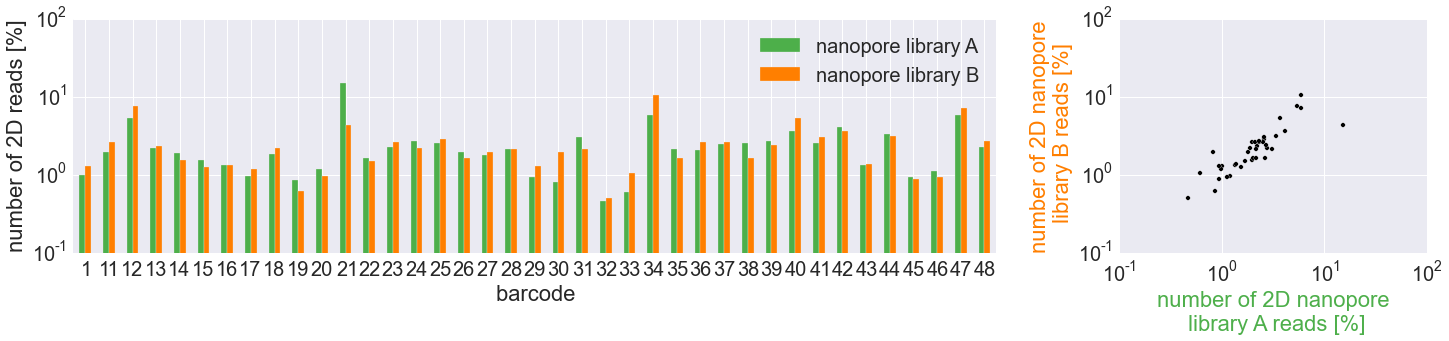

In [75]:
def getBarcodeDistribution(thisFilePath):
    """
    Return a list with containing the amount of records in each barcode
    Parameter:
    thisFilePath = path to fasta file
    
    """
    barcodeCount = [0] * 49
    
    assert type(thisFilePath) is StringType, "thisFilePath is not a string: %r" % thisFilePath 
        
    #Test inputs
    if not os.path.isfile(thisFilePath):
        raise IOError('thisFilePath does not excist',thisFilePath)
        
        
    lenList = []
    for record in SeqIO.parse(thisFilePath, "fasta"): #Read in the raw  reads
        
        thisBarcode = int(record.id.split('_')[1]) #Extract barcode number
        barcodeCount[thisBarcode] += 1
        #lenList.append(len(record)) #Store all the raw lengths in a list
    #return lenList
    return barcodeCount

dfDemux = pd.DataFrame(columns=[['nanopore library A','nanopore library B']])
dfDemux['nanopore library A'] = getBarcodeDistribution(qPathOrdered['MI_demux'])
dfDemux['nanopore library B'] = getBarcodeDistribution(qPathOrdered['MIpc_demux'])

pp = PdfPages('figures/Fig02_BarcodeDistribution_percentageofread.v2.pdf')

plt.style.reload_library()
plt.style.use('ggplot_evdh')

sns.set(font_scale=2) 
fig, ax = plt.subplots(1,2, gridspec_kw = {'width_ratios':[3, 1]},figsize=(20,5))
sns.despine()
ax[0] = (dfDemux.ix[[1]+range(11,49)]/dfDemux.ix[[1]+range(11,49)].sum()*100).plot(kind='bar',ax=ax[0],logy=True,color=[colorSet['MI'],colorSet['MIpc']])
ax[0].set_xlabel('barcode ')
ax[0].set_ylabel('number of 2D reads [%]')


ax[1]= (dfDemux.ix[[1]+range(11,49)]/dfDemux.ix[[1]+range(11,49)].sum()*100).plot(ax=ax[1],x='nanopore library A',y='nanopore library B',kind='scatter',color='black',logy=True,logx=True)
ax[1].set_xlabel('number of 2D nanopore\n library A reads [%]',color=colorSet['MI'])
ax[1].set_ylabel('number of 2D nanopore\n library B reads [%]',color=colorSet['MIpc'])

labels = ax[0].get_xticklabels()
newLabel =[]
for thisLabel in labels:
    
    newLabel.append(thisLabel.get_text())
    
ax[0].set_xticklabels(newLabel, rotation='horizontal')


plt.gcf().subplots_adjust(left=0.05,right=0.99,bottom=0.25)
pp.savefig()
pp.close()
print "Barcode distribution of nanopore library A (green ,%s 2D reads) and nanopore library B (orange,%s 2D reads)" % (dfDemux.ix[[1]+range(11,49)]['nanopore library A'].sum(),dfDemux.ix[[1]+range(11,49)]['nanopore library B'].sum())

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(np.log10(dfDemux.ix[[1]+range(11,49)]['nanopore library A']),np.log10(dfDemux.ix[[1]+range(11,49)]['nanopore library B']))
#print slope, intercept, r_value,p_value,std_err
#print r_value**2
print "The Pearson correlation test (R^2 = %s, p< %s) showed significance of relationship between the two libraries."% (round(r_value**2,2),round(p_value,12))

## 3b. Barcode distribution nanopore vs pacbio
additionally for in the supplemantary information we compare the abundance between library A and the pacbio library

Barcode distribution of nanopore library A (green ,24126 2D reads) and nanopore library B (orange,3361 2D reads) and the PacBio library (blue, 67497 reads) 
The Pearson correlation test (R^2 = 0.42, p< 1e-05) showed significance of relationship between the nanopore A and PacBio libraries.


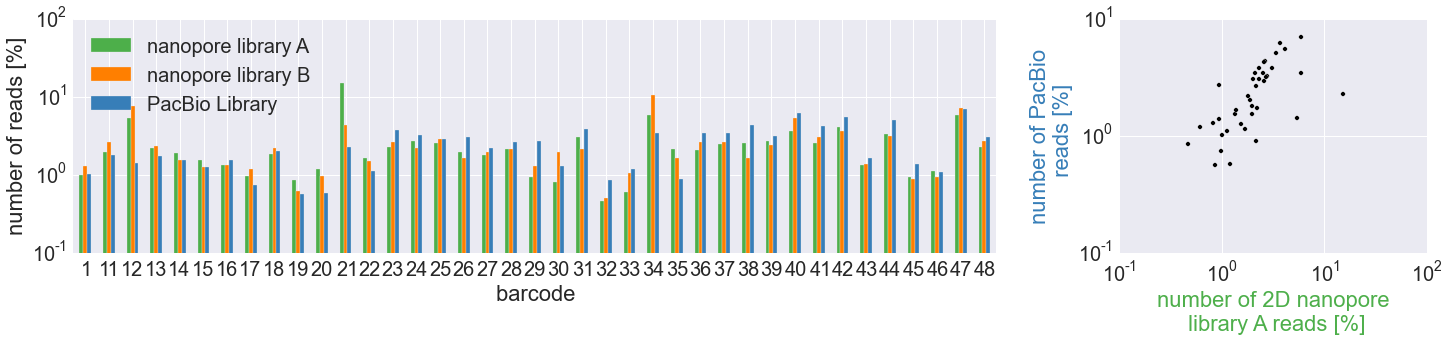

In [76]:

def getBarcodeDistribution(thisFilePath):
    """
    Return a list with containing the amount of records in each barcode
    Parameter:
    thisFilePath = path to fasta file
    
    """
    barcodeCount = [0] * 49
    
    assert type(thisFilePath) is StringType, "thisFilePath is not a string: %r" % thisFilePath 
        
    #Test inputs
    if not os.path.isfile(thisFilePath):
        raise IOError('thisFilePath does not excist',thisFilePath)
        
        
    lenList = []
    for record in SeqIO.parse(thisFilePath, "fasta"): #Read in the raw  reads
        
        thisBarcode = int(record.id.split('_')[1]) #Extract barcode number
        barcodeCount[thisBarcode] += 1
        #lenList.append(len(record)) #Store all the raw lengths in a list
    #return lenList
    return barcodeCount

dfDemux = pd.DataFrame(columns=[['nanopore library A','nanopore library B','PacBio Library']])
dfDemux['nanopore library A'] = getBarcodeDistribution(qPathOrdered['MI_demux'])
dfDemux['nanopore library B'] = getBarcodeDistribution(qPathOrdered['MIpc_demux'])

dfPBDemux = pd.DataFrame()
dfPBDemux = pd.read_pickle(pacbioMuxData) #Dataframe with the pacbio demux data
dfTmp = dfPBDemux.barcode.value_counts().sort_index()
dfTmp.set_value(0, 0)
dfDemux['PacBio Library'] = dfTmp.sort_index().tolist()

#dfDemux['PacBio Library'] = getBarcodeDistribution(qPathOrdered['PB_ass'])

pp = PdfPages('figures/FigS04_BarcodeDistribution_percentageofread_pb.pdf')

plt.style.reload_library()
plt.style.use('ggplot_evdh')

sns.set(font_scale=2) 
fig, ax = plt.subplots(1,2, gridspec_kw = {'width_ratios':[3, 1]},figsize=(20,5))
sns.despine()
ax[0] = (dfDemux.ix[[1]+range(11,49)]/dfDemux.ix[[1]+range(11,49)].sum()*100).plot(kind='bar',ax=ax[0],logy=True,color=[colorSet['MI'],colorSet['MIpc'],colorSet['PB']])
ax[0].set_xlabel('barcode ')
ax[0].set_ylabel('number of reads [%]')


ax[1]= (dfDemux.ix[[1]+range(11,49)]/dfDemux.ix[[1]+range(11,49)].sum()*100).plot(ax=ax[1],x='nanopore library A',y='PacBio Library',kind='scatter',color='black',logy=True,logx=True)
ax[1].set_xlabel('number of 2D nanopore\n library A reads [%]',color=colorSet['MI'])
ax[1].set_ylabel('number of PacBio\n  reads [%]',color=colorSet['PB'])

labels = ax[0].get_xticklabels()
newLabel =[]
for thisLabel in labels:
    
    newLabel.append(thisLabel.get_text())
    
ax[0].set_xticklabels(newLabel, rotation='horizontal')


plt.gcf().subplots_adjust(left=0.05,right=0.99,bottom=0.25)
pp.savefig()
pp.close()
#####print "Barcode distribution of nanopore library A (green ,%s 2D reads) and PacBio Library (orange,%s 2D reads)" % (dfDemux.ix[[1]+range(11,49)]['nanopore library A'].sum(),dfDemux.ix[[1]+range(11,49)]['nanopore library B'].sum())
print "Barcode distribution of nanopore library A (green ,%s 2D reads) and nanopore library B (orange,%s 2D reads) and the PacBio library (blue, %s reads) " % (dfDemux.ix[[1]+range(11,49)]['nanopore library A'].sum(),dfDemux.ix[[1]+range(11,49)]['nanopore library B'].sum(),dfDemux.ix[[1]+range(11,49)]['PacBio Library'].sum())

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(np.log10(dfDemux.ix[[1]+range(11,49)]['nanopore library A']),np.log10(dfDemux.ix[[1]+range(11,49)]['PacBio Library']))
#print slope, intercept, r_value,p_value,std_err
#print r_value**2
print "The Pearson correlation test (R^2 = %s, p< %s) showed significance of relationship between the nanopore A and PacBio libraries."% (round(r_value**2,2),round(p_value,5))

# 4. Sequence identity against the Sanger dataset & CARD database
The Sangerdataset is supposed to have high quality reads, therefor we can use it to benchmark the PacBio and nanopore data against (the datasets were BLAST'ed againt the Sangerdataset in ```calculateResistome.ipynb```. Furthermore the sequence identity for the hits found in the CARD database either by ```calculateResistome.ipynb``` for the PacBio and Sanger set and by ```poreFUME.py``` in the nanopore set are depiced alongside

_Note on the sanger dataset:_
First trim the Sanger sequences on quality and vector (Lejla did this in CLC)
Next assemble these reads (using CLC) into contigs. Export using 'Sequence CSV' in 'batch' mode so each contig has its own file. Run it with log and store the sequences that are NOT assembled. CLC will not give the non-assembled sequence, so we will retreive those as well. Finally put everything together in one dataframe and convert to Fasta so mustafa can annotate this set. This dataframe can be found in the pickle


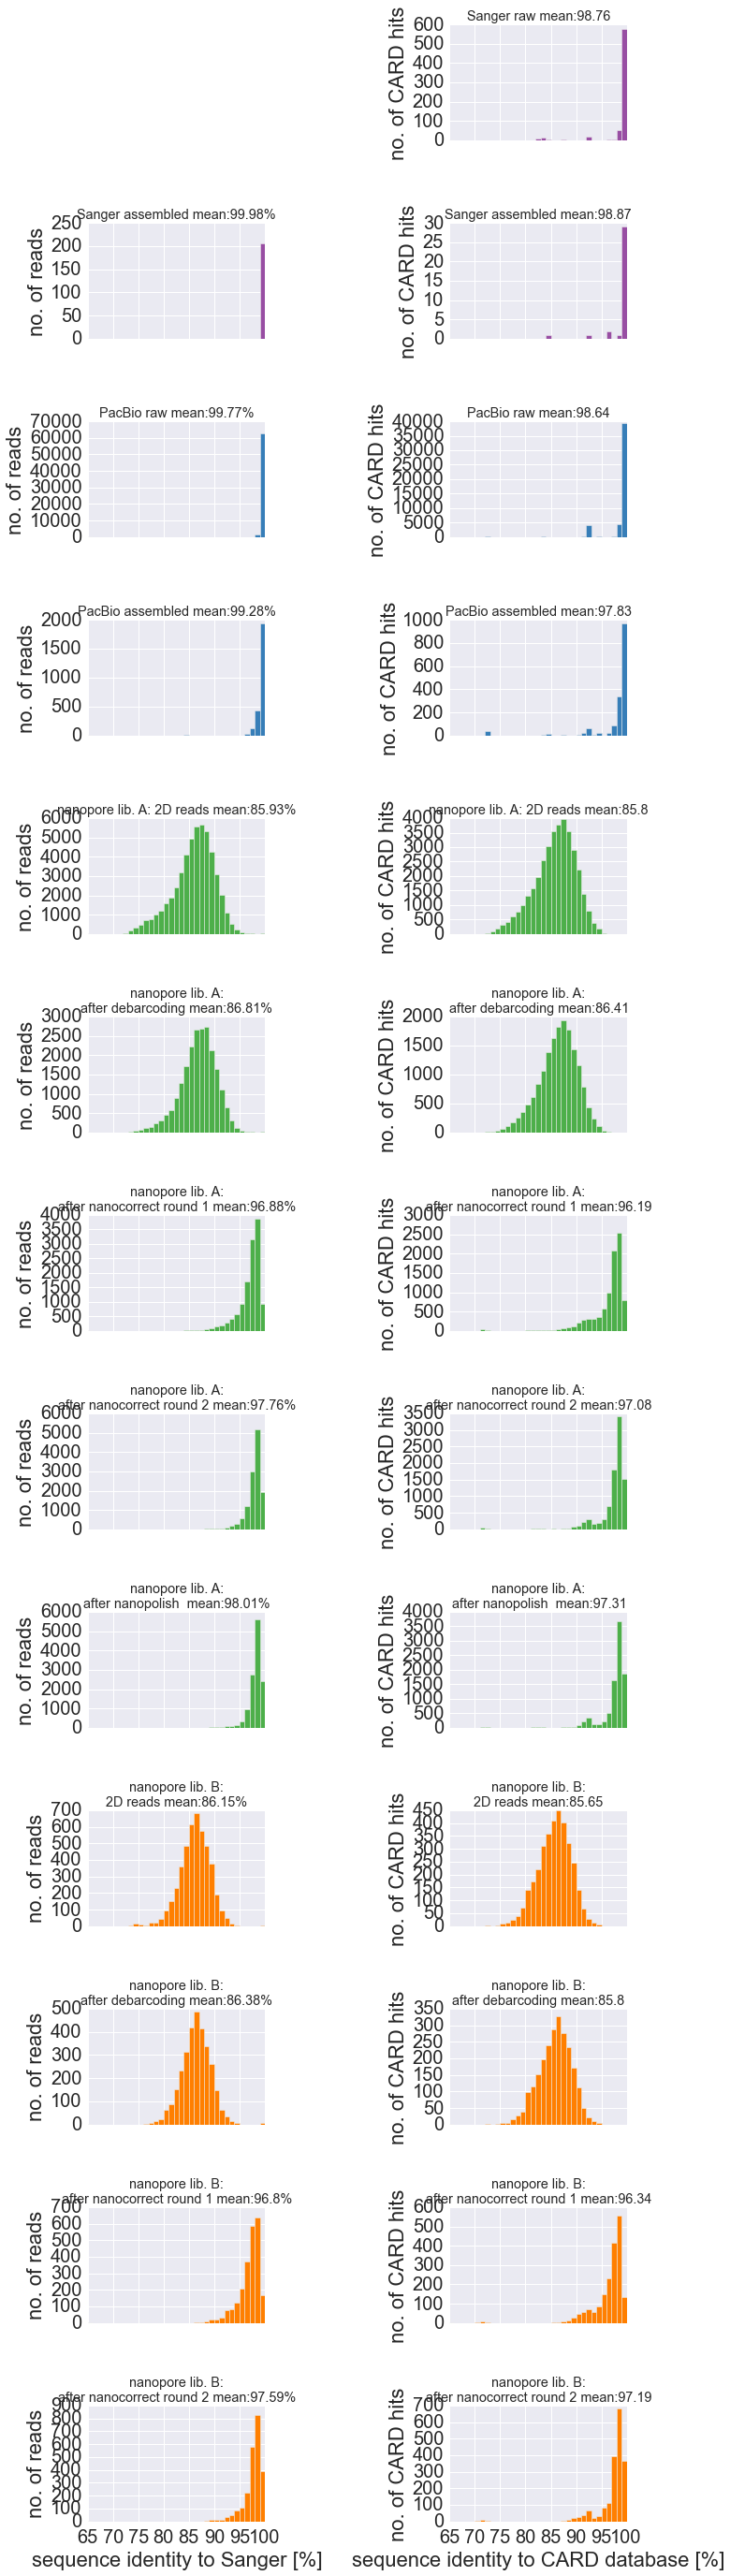

In [77]:


from matplotlib.backends.backend_pdf import PdfPages 
pp = PdfPages('figures/FigS02_seqid_to_Sanger_and_CARD.v2.pdf')

from matplotlib import pyplot as plt
sns.despine()
fig, axs = plt.subplots(len(annotationPathOrdered),2,figsize=(10,39),sharex=True)
fig.tight_layout(h_pad=3,w_pad=7)


plt.style.reload_library()
plt.style.use('ggplot_evdh')
#sns.set(font_scale=1) 
counter = 1 #start with 1 because we didnt blast sanger raw against sanger raw
fig.delaxes(axs[0,0]) #remove sanger against sanger from the whole subplot overview

for thisRunName, thisQueryFile in againstSangerPathOrdered.items():  

    thisDF = pd.read_csv(againstSangerPathOrdered[thisRunName]) #load annotated sanger reads
 
    #ax = thisDF['pident'].hist(bins=range(65,101),label=thisRunName,ax=axs[counter][0],color=colorSet[thisRunName.split('_')[0]])
    
    ax = sns.distplot(thisDF['pident'],bins=range(65,101), kde=False,color=colorSet[thisRunName.split('_')[0]],ax=axs[counter][0],label=thisRunName,hist_kws={"alpha": 1})
    ax.set_title( readLabels[thisRunName] + ' mean:' + str(round(thisDF['pident'].mean(),2)) + '% ')
    
    if thisRunName.split('_')[1] == 'raw':
        ax.set_ylabel('no. of reads')
    else:
        ax.set_ylabel('no. of reads')
    ax.set_xlabel('')
    counter +=1


ax.set_xlabel('sequence identity to Sanger [%]')

counter = 0
for thisRunName, thisQueryFile in annotationPathOrdered.items():  

    thisDF = pd.read_csv(annotationPathOrdered[thisRunName]) #load annotated sanger reads
#    ax = thisDF[thisDF['CARD:coverageOfSubjectGene']>50]['CARD:pident'].hist(bins=range(65,101),ax=axs[counter][1],color=colorSet[thisRunName.split('_')[0]])
    ax = sns.distplot(thisDF[thisDF['CARD:coverageOfSubjectGene']>50]['CARD:pident'],bins=range(65,101), kde=False,color=colorSet[thisRunName.split('_')[0]],ax=axs[counter][1],label=thisRunName,hist_kws={"alpha": 1})
    ax.set_title(readLabels[thisRunName] + ' mean:' + str(round(thisDF[thisDF['CARD:coverageOfSubjectGene']>50]['CARD:pident'].mean(),2)))
    ax.set_ylabel('no. of CARD hits')
    ax.set_xlabel('')
    counter +=1
ax.set_xlabel('sequence identity to CARD database [%]')
plt.gcf().subplots_adjust(left=0.1,right=0.9,top=0.99,bottom=0.04)

pp.savefig()
pp.close()

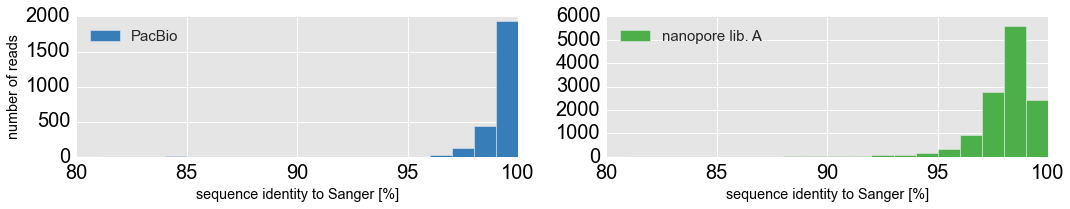

In [78]:
from matplotlib.backends.backend_pdf import PdfPages 
pp = PdfPages('figures/Fig05_seqid_to_Sanger.v2.pdf')

from matplotlib import pyplot as plt
sns.despine()
fig, axs = plt.subplots(1,2,figsize=(15,3))
#fig.tight_layout(h_pad=3,w_pad=7)

sns.set(font_scale=1.5) 
plt.style.reload_library()
plt.style.use('ggplot_evdh')
#sns.set(font_scale=1) 
counter = 0 #start with 1 because we didnt blast sanger raw against sanger raw

subDict = { thisKey: againstSangerPathOrdered[thisKey] for thisKey in ['MI_polishNoFilter','PB_ass'] } #slice out only the final two datasets

for thisRunName, thisQueryFile in subDict.items():  

    thisDF = pd.read_csv(againstSangerPathOrdered[thisRunName]) #load annotated sanger reads
 
    #ax = thisDF['pident'].hist(bins=range(65,101),label=thisRunName,ax=axs[counter][0],color=colorSet[thisRunName.split('_')[0]])
    
    ax = sns.distplot(thisDF['pident'],bins=range(80,101), kde=False,color=colorSet[thisRunName.split('_')[0]],ax=axs[counter],label=thisRunName,hist_kws={"alpha": 1})
    #ax.set_title( readLabels[thisRunName] + ' mean:' + str(round(thisDF['pident'].mean(),2)) + '% ')
    
    if counter ==0:
        ax.set_ylabel('number of reads')
    else:
        pass
    ax.set_xlabel('')
    counter +=1

    ax.legend([readLabelsSample[thisRunName]],loc='upper left')
    ax.set_xlabel('sequence identity to Sanger [%]')

plt.gcf().subplots_adjust(left=0.07,right=0.97,top=0.85,bottom=0.2)
pp.savefig()
pp.close()


# 5. CARD annotation of the nanopore library B and PacBio dataset
Since the metagenomic selection was performed on antibiotics, we annotated the sequencing data with the [CARD database](https://card.mcmaster.ca/) (Comprehensive Antibiotic Research Database) database to gain functional insights. Please cite [McArthur et al. 2013. The Comprehensive Antibiotic Resistance Database. Antimicrobial Agents and Chemotherapy, 57, 3348-3357.](http://www.ncbi.nlm.nih.gov/pubmed/23650175)

In [79]:
dfMIp3 = pd.read_csv(annotationPathOrdered['MI_polishNoFilter']) 
dfPB = pd.read_csv(annotationPathOrdered['PB_ass']) #load annotated pacbio reads
dfS = pd.read_csv(annotationPathOrdered['S_ass'])

def getBarcode(row):
    """
    Extract the barcode from the FASTA header created by poreFUME
    >BC_3_readname extracts 3
    """
    #print row
    return int(str(row['CARD:qseqid']).split('_')[1])



dfMIp3['MinIONBarcode'] = dfMIp3.apply(getBarcode, axis=1) #Decode the barcode in the query name and save as seperate collumn

#The samples are barcoded per 96-well plate. The exact layout is in the Adapterlist. 
dfConvert = pd.read_csv('inputFiles/expData/LI6 AdapterList.txt',delimiter='\t') #Lejla stored the plates and corresponding pacbio adapters here
dfConvert.rename(columns={'Adapter': 'MinIONBarcode', 'Sample': 'MinIONPlate'}, inplace=True)
dfMIp3 = pd.merge(dfMIp3, dfConvert, how='left', on=['MinIONBarcode']) #Merge barcodes and plates onto the CARD BLAST hits


In [80]:
def getRecordSize(thisFilePath):
    """
    Return a int with the number of records in  the fasta file
    Parameter:
    thisFilePath = path to fasta file
    
    """
    assert type(thisFilePath) is StringType, "thisFilePath is not a string: %r" % thisFilePath 
        
    #Test inputs
    if not os.path.isfile(thisFilePath):
        raise IOError('thisFilePath does not exist',thisFilePath)
        
        
    
    return len(list(SeqIO.parse(thisFilePath, "fasta")))
getRecordSize(qPathOrdered['MI_raw'])

SangerSize = getRecordSize(qPathOrdered['S_ass'])
PBSize = getRecordSize(qPathOrdered['PB_ass'])
MISize = getRecordSize(qPathOrdered['MI_polishNoFilter'])

In [81]:
dfAssembly = pd.read_pickle('inputFiles/SangerAssembly.withoutCandT.pckl') #Contains a formatted CLC export with the amount of reads contained in a contig
dfAssembly= dfAssembly.fillna(1)
dfAssembly
dfS = dfS.merge(dfAssembly, left_on='CARD:qseqid', right_on='name', how='left') #Merge the contig size onto the annotation file from the Sanger data

In [82]:
def maskClose(row):
    """
    The TEM and CTX genes are extremly similair with SNPs differences. In order to 
    make the comparison between the different techniques more straightforward we mask the CTX and TEM genes as 
    one category. Same goes for SRT and MIR. Alternativly, we can first cluster the CARD database at 95% and then perform
    annotation
    """
    #print row
    
    if str(row['CARD:GeneName'])[0:3] == 'CTX':
        return 'CTX'
    elif str(row['CARD:GeneName'])[0:3] == 'TEM':
        return 'TEM'
    elif str(row['CARD:GeneName'])[0:3] == 'SRT':
        return 'SRT'
    elif str(row['CARD:GeneName'])[0:3] == 'MIR':
        return 'MIR'
    else:
        return row['CARD:GeneName']


dfMIp3['CARD:newGeneName'] = dfMIp3.apply(maskClose,axis=1)
dfPB['CARD:newGeneName'] = dfPB.apply(maskClose,axis=1)
dfS['CARD:newGeneName'] = dfS.apply(maskClose,axis=1)

Abundance of 26 CARD genes in the Sanger (green), PacBio (blue) and nanopore (green) dataset as show as fraction of the total reads contained in each dataset. The 4 genes (mel, tetC, tetQ, tetX) are not found in the Sanger dataset but are present in the PacBio and nanopore set.  
With a CARD cut-off >80 % sequence identity and >50 % gene converage 


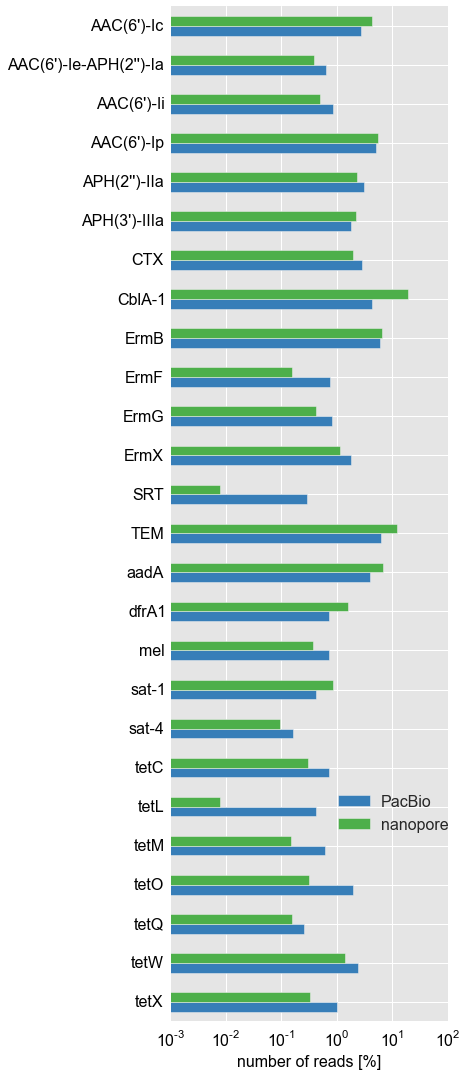

In [83]:
minCoverage = 50
minIdentity = 80

pp = PdfPages('figures/Fig03_CARDcounts.v2.pdf')



plt.style.reload_library()
plt.style.use('ggplot_evdh')

fig, ax = plt.subplots()
#fig.tight_layout(h_pad=3,w_pad=1)


sns.despine()
#sns.set(font_scale=2)

#Extract all the annotations that >minIdentity and >geneCoverage, next calculate as percentage of the total amount of reads that were present. For the Sanger set we count the amount of reads in a contig in the 'contigSize' column (which we loaded in previously from the pickle file)
sanger = dfS[(dfS['CARD:coverageOfSubjectGene']>minCoverage)&(dfS['CARD:pident']>minIdentity)].groupby('CARD:newGeneName')['contigSize'].sum()/SangerSize*100
pacbio = dfPB[(dfPB['CARD:coverageOfSubjectGene']>minCoverage)&(dfPB['CARD:pident']>minIdentity)].groupby('CARD:newGeneName')['CARD:pident'].size()/PBSize*100
nanoporep3 = dfMIp3[(dfMIp3['CARD:coverageOfSubjectGene']>minCoverage)&(dfMIp3['CARD:pident']>minIdentity)].groupby('CARD:newGeneName')['CARD:pident'].size()/MISize*100



mergeAnnoation = pd.concat([sanger.to_frame(name='Sanger'),pacbio.to_frame(name='PacBio'),nanoporep3.to_frame(name='nanopore')], axis=1)

#Uncomment the following line to also put the Sanger data in this plot. The downside is that the sanger set is a subsample of the whole dataset, so we will see gaps in the sanger annotation. 
#ax1 = mergeAnnoation.sort_index(ascending=False).plot(kind='barh',logx=True,figsize=(7,20),color=[colorSet['S'],colorSet['PB'],colorSet['MI']],ax=ax) #Sort reverse so barh is again correctly sorted

ax1 = mergeAnnoation[['PacBio','nanopore']].sort_index(ascending=False).plot(kind='barh',logx=True,figsize=(7,15),color=[colorSet['PB'],colorSet['MI']],ax=ax) #Sort reverse so barh is again correctly sorted

ax1.set_xlabel('number of reads [%]', fontsize=16)
plt.yticks(ax1.get_yticks(), fontsize=16)
plt.xticks(ax1.get_xticks(), fontsize=16)
ax1.set_xlim([0.001,100])

#ax1.set_xlim([0.005,100])
ax1.legend(loc=(0.58,0.18),fontsize=16)
plt.gcf().subplots_adjust(left=0.4,right=0.95,top=0.99,bottom=0.05)
pp.savefig()
pp.close()

print "Abundance of %s CARD genes in the Sanger (green), PacBio (blue) and nanopore (green) dataset as show as fraction of the total reads contained in each dataset. The %s genes (%s) are not found in the Sanger dataset but are present in the PacBio and nanopore set.  " % (mergeAnnoation.shape[0], mergeAnnoation[mergeAnnoation.Sanger.isnull()].shape[0] ,", ".join(mergeAnnoation[mergeAnnoation.Sanger.isnull()].index.tolist()) )
print "With a CARD cut-off >%s %% sequence identity and >%s %% gene converage " % ( minIdentity,minCoverage)

# 6. Correlation between the PacBio and nanopore set as measured by CARD annotations
The above 26*2 bars can be transformed into 26 datapoints on 2 dimensions (PacBio vs nanopore abundance) to investigate the correlation

The Pearson correlation test (R^2 = 0.71, p< 1e-07) of the log transformed abundance showed significance relationship between the nanopore and PacBio dataset as assesed by proportion of log transformed CARD hits found. Treshold for CARD identification are gene coverage of x% and x% sequence identity.


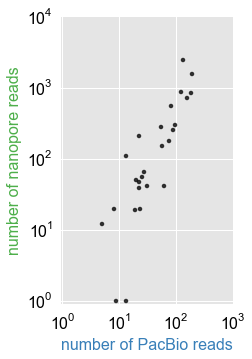

In [84]:
sanger = dfS[(dfS['CARD:coverageOfSubjectGene']>minCoverage)&(dfS['CARD:pident']>minIdentity)].groupby('CARD:newGeneName')['contigSize'].sum()
pacbio = dfPB[(dfPB['CARD:coverageOfSubjectGene']>minCoverage)&(dfPB['CARD:pident']>minIdentity)].groupby('CARD:newGeneName')['CARD:pident'].size()
nanoporep3 = dfMIp3[(dfMIp3['CARD:coverageOfSubjectGene']>minCoverage)&(dfMIp3['CARD:pident']>minIdentity)].groupby('CARD:newGeneName')['CARD:pident'].size()



mergeAnnoationABS = pd.concat([sanger.to_frame(name='Sanger'),pacbio.to_frame(name='PacBio'),nanoporep3.to_frame(name='nanopore')], axis=1)

from matplotlib.backends.backend_pdf import PdfPages 
pp = PdfPages('figures/Fig04_CARDRelationPacBioNanoporeB.v2.pdf')

from matplotlib import pyplot as plt
f, ax = plt.subplots(figsize=(4, 5))
ax.set(xscale="log", yscale="log")

#
#ax= mergeAnnoationABS.plot(x='PacBio',y='nanopore',kind='scatter',logy=True,logx=True,color='black')
ax = sns.regplot(x="PacBio", y="nanopore", data=mergeAnnoationABS,ax=ax,truncate=True,fit_reg=False,color='black')
#ax.set_yscale('symlog',linthresy='0.00077')
#ax.set_xscale('symlog',linthresx='0.00077')
#ax.set_xticklabels(['0','1','10','100'])
#ax.set_yticklabels(['0','1','10','100'])



#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_xlabel('number of PacBio reads',color=colorSet['PB'],fontsize=16)
ax.set_ylabel('number of nanopore reads',color=colorSet['MI'],fontsize=16)
plt.yticks(ax.get_yticks(), fontsize=16)
plt.xticks(ax.get_xticks(), fontsize=16)
ax.set_xlim([0.9,1000])
ax.set_ylim([0.9,10000])
#sns.despine()

plt.gcf().subplots_adjust(top=0.95,bottom=0.15,right=0.8,left=0.2)
pp.savefig()
pp.close()

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(np.log10(mergeAnnoationABS['PacBio']),np.log10(mergeAnnoationABS['nanopore']))
print "The Pearson correlation test (R^2 = %s, p< %s) of the log transformed abundance showed significance relationship between the nanopore and PacBio dataset as assesed by proportion of log transformed CARD hits found. Treshold for CARD identification are gene coverage of x%% and x%% sequence identity."% (round(r_value**2,2),round(p_value,7)) 


# 7. Sequence identity of all the identified genes
We can dive into each individual gene and see the sequence identity distribution. Overlayed are the PacBio and nanopore sequence identity

['tetW', 'tetO', 'tetQ', 'tetM', 'mel', 'TEM', 'tetL', 'tetX', 'CblA-1', 'CTX', "APH(2'')-IIa", "AAC(6')-Ip", 'aadA', 'dfrA1', 'sat-1', "APH(3')-IIIa", 'sat-4', 'ErmX', 'ErmB', "AAC(6')-Ie-APH(2'')-Ia", 'ErmG', 'SRT', 'tetC', "AAC(6')-Ii", 'ErmF', "AAC(6')-Ic", 'CMY-38', 'CMY-15', 'MIR', 'ACT-37']
AAC(6')-Ic
AAC(6')-Ie-APH(2'')-Ia
AAC(6')-Ii
AAC(6')-Ip
ACT-37
APH(2'')-IIa
APH(3')-IIIa
CMY-15
CMY-38
CTX
CblA-1
ErmB
ErmF
ErmG
ErmX
MIR
SRT
TEM
aadA
dfrA1
mel
sat-1
sat-4
tetC
tetL
tetM
tetO
tetQ
tetW
tetX


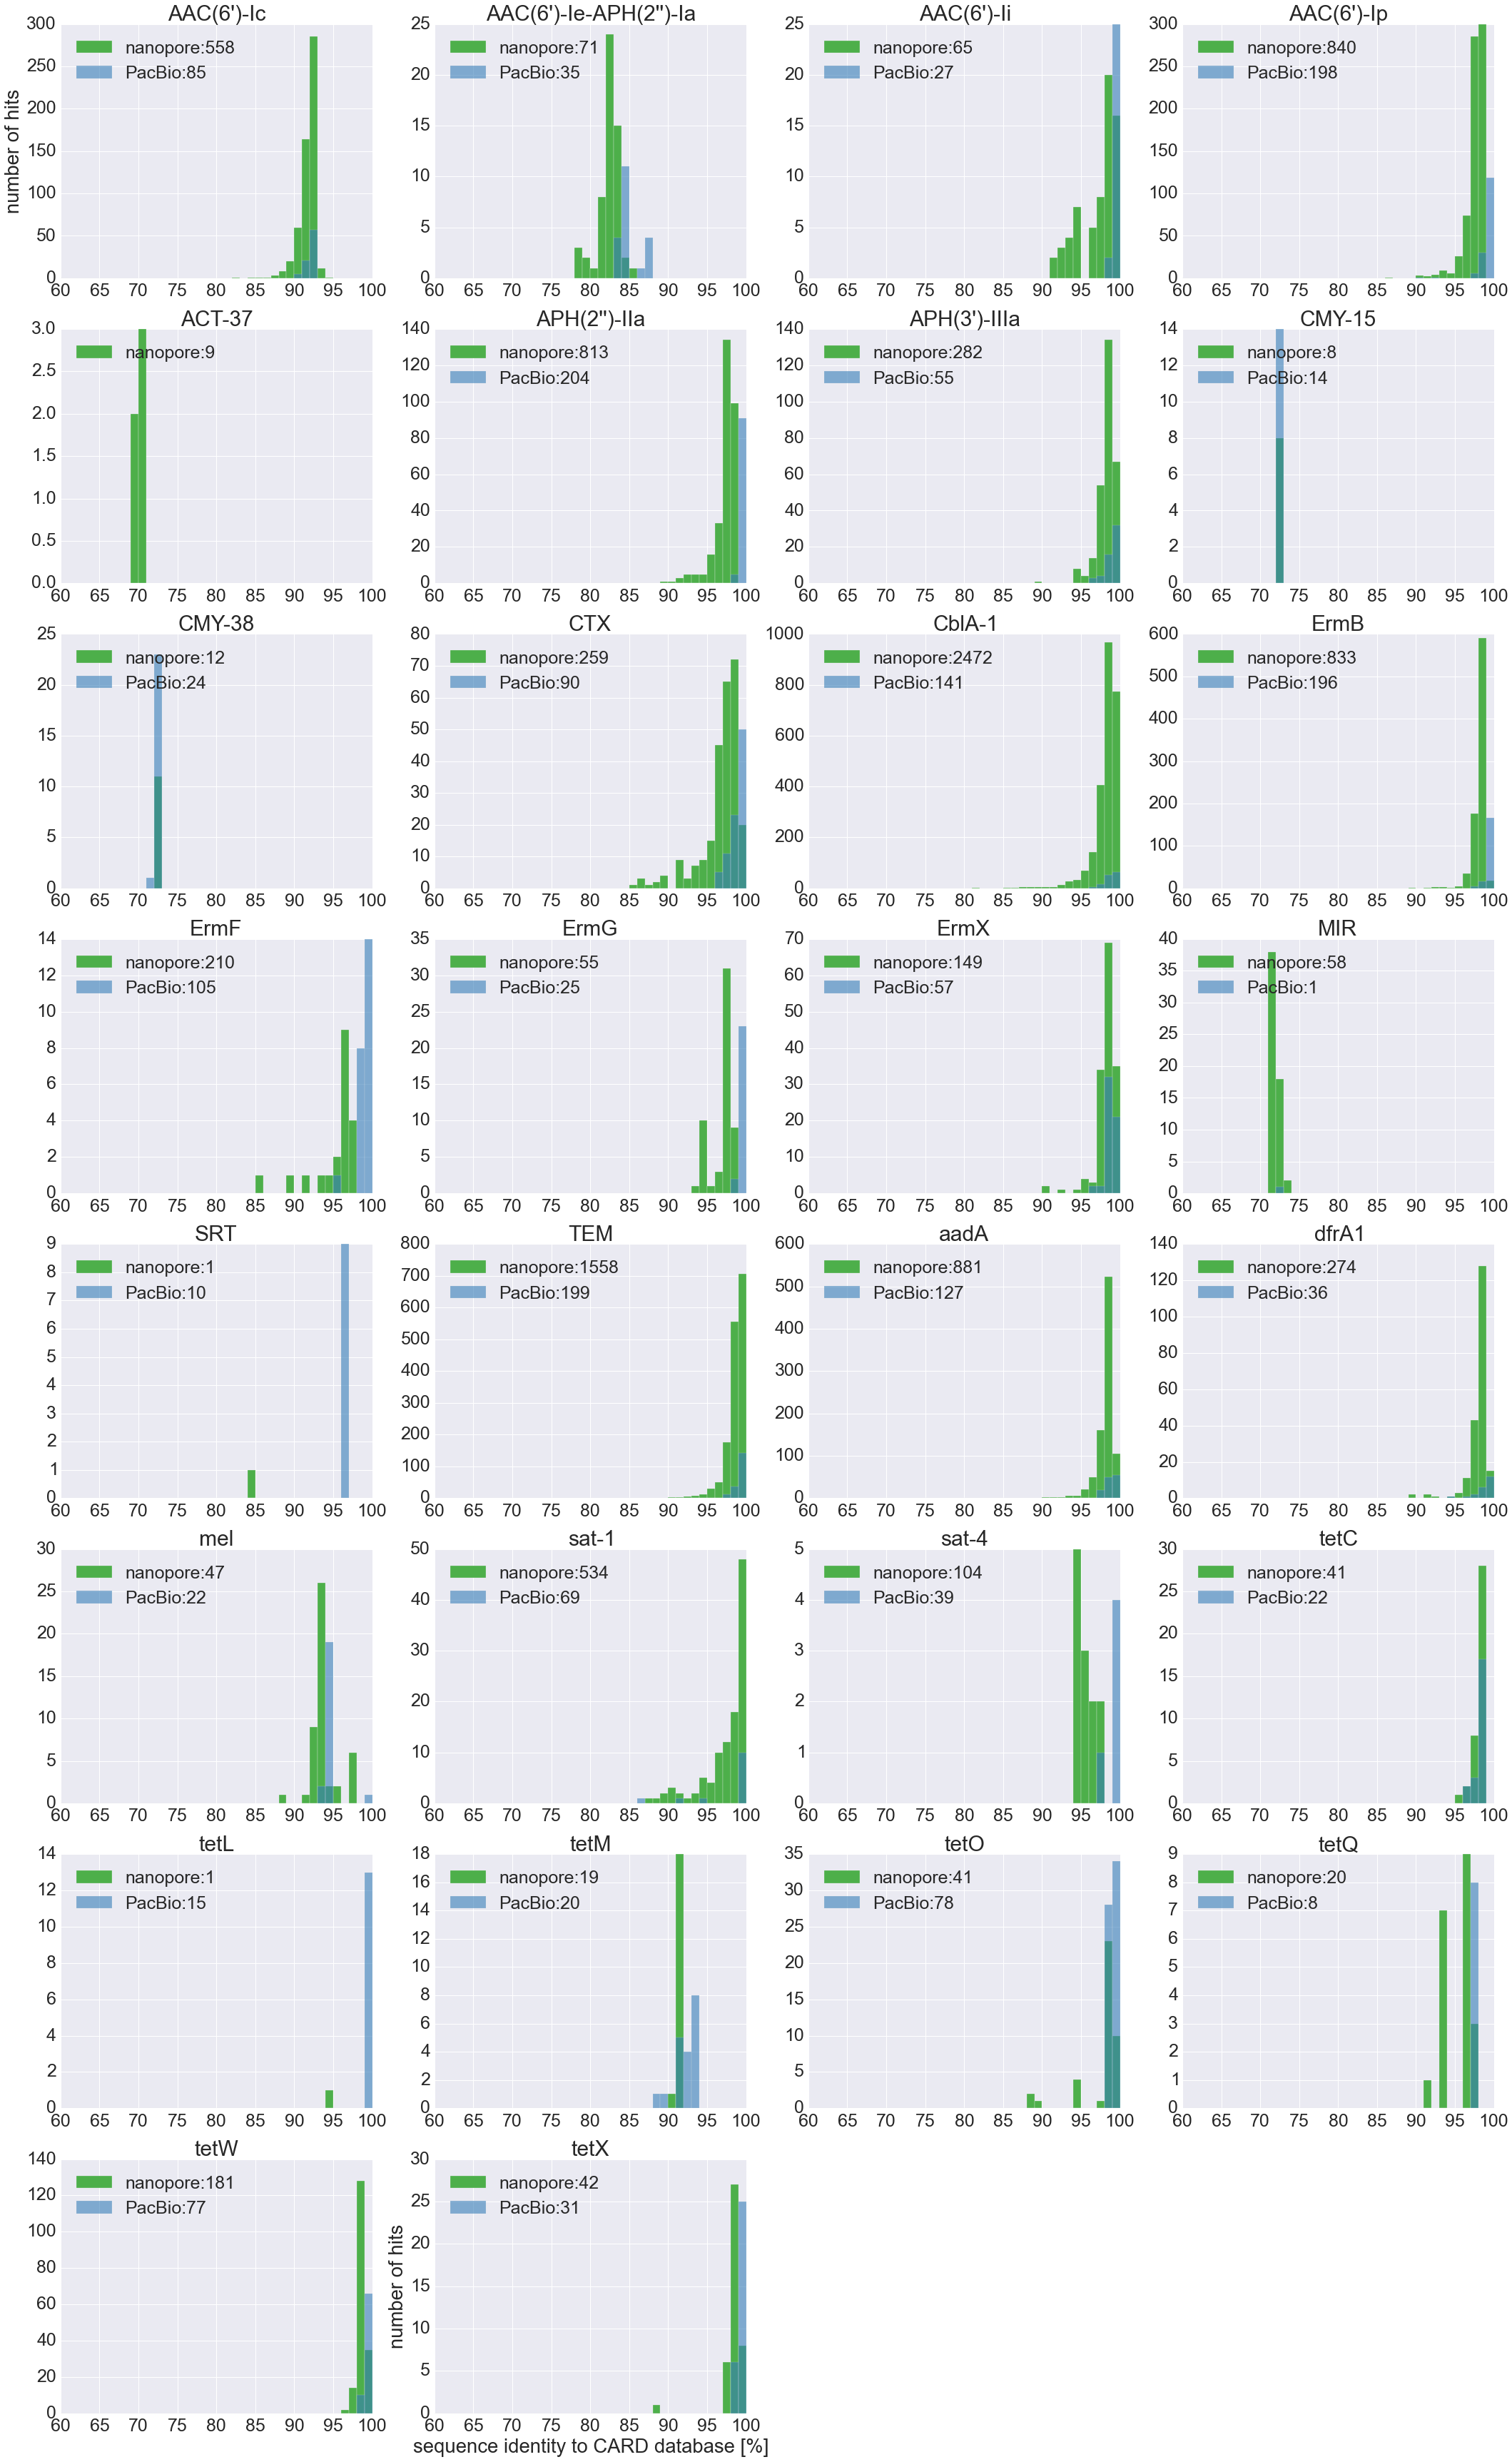

In [85]:

pp = PdfPages('figures/FigS03_individualGeneSeqId.v2.pdf')
counter = 1
bins = range(60,101)
fig = plt.figure(figsize=(30,50))

sns.set(font_scale=2.5)
allGenes =dfMIp3[dfMIp3['CARD:coverageOfSubjectGene']>50]['CARD:newGeneName'].unique().tolist()# set([dfMIp3['CARD:newGeneName'].unique().tolist(), dfPB['CARD:newGeneName'].unique().tolist()])
#print [me for thisGene in list(allGenes) if thisGene is not None]

cleanList =  [x for x in list(allGenes) if x is not 'None']
print cleanList
for thisGene in sorted(cleanList):
 
    #if counter == 0:
    #    counter = counter + 1
    #    continue
    
    print thisGene
    #fig, ax1 = plt.subplots(figsize=(5, 2))
 
    ax1 = plt.subplot(8,4,counter)
    ax1.set_title(thisGene)

    if len(dfMIp3[(dfMIp3['CARD:coverageOfSubjectGene']>50) & (dfMIp3['CARD:newGeneName'] == thisGene)]['CARD:pident'])>1:
        #plt.figure(counter)  
        #dfMIp3[dfMIp3['CARD:HitID'] == thisGene]['CARD:pident'].hist()
        
        #ax1.hist(dfMIp3[(dfMIp3['CARD:coverageOfSubjectGene']>50) & (dfMIp3['CARD:newGeneName'] == thisGene)]['CARD:pident'].values,alpha=1,bins=bins,color=colorSet['MI'],label='nanopore:'+str(len(dfMIp3[dfMIp3['CARD:newGeneName'] == thisGene]['CARD:pident'])))
        sns.distplot(dfMIp3[(dfMIp3['CARD:coverageOfSubjectGene']>50) & (dfMIp3['CARD:newGeneName'] == thisGene)]['CARD:pident'].values,bins=bins, kde=False,color=colorSet['MI'], ax=ax1,hist_kws={"alpha": 1},label='nanopore:'+str(len(dfMIp3[dfMIp3['CARD:newGeneName'] == thisGene]['CARD:pident'])))
        
        ax1.set_title(dfMIp3[(dfMIp3['CARD:coverageOfSubjectGene']>50) & (dfMIp3['CARD:newGeneName'] == thisGene)]['CARD:newGeneName'].values[0]  )
        #print 'jaj'
        #ax1.set_xlim[50,100]
    elif len(dfMIp3[(dfMIp3['CARD:coverageOfSubjectGene']>50) & (dfMIp3['CARD:newGeneName'] == thisGene)]['CARD:pident'])==1:
        ax1.hist([0]+dfMIp3[(dfMIp3['CARD:coverageOfSubjectGene']>50) & (dfMIp3['CARD:newGeneName'] == thisGene)]['CARD:pident'].values,alpha=1,color=colorSet['MI'],bins=bins,label='nanopore:'+str(len(dfMIp3[dfMIp3['CARD:newGeneName'] == thisGene]['CARD:pident'])))
        ax1.set_title(dfMIp3[(dfMIp3['CARD:coverageOfSubjectGene']>50) & (dfMIp3['CARD:newGeneName'] == thisGene)]['CARD:newGeneName'].values[0]  )
        
    if len(dfPB[(dfPB['CARD:newGeneName'] == thisGene) & (dfPB['CARD:coverageOfSubjectGene']>50)]['CARD:pident'])>1:
        ax1.hist(dfPB[(dfPB['CARD:newGeneName'] == thisGene) & (dfPB['CARD:coverageOfSubjectGene']>50)]['CARD:pident'].values,bins=bins,alpha=0.6,color=colorSet['PB'],label='PacBio:'+str(len(dfPB[dfPB['CARD:newGeneName'] == thisGene]['CARD:pident'])))
        ax1.set_title(dfPB[(dfPB['CARD:newGeneName'] == thisGene) & (dfPB['CARD:coverageOfSubjectGene']>50)]['CARD:newGeneName'].values[0]  )
    elif len(dfPB[(dfPB['CARD:newGeneName'] == thisGene) & (dfPB['CARD:coverageOfSubjectGene']>50)]['CARD:pident'])==1:
        ax1.hist([0]+dfPB[(dfPB['CARD:newGeneName'] == thisGene) & (dfPB['CARD:coverageOfSubjectGene']>50)]['CARD:pident'].values,bins=bins,alpha=0.6,color=colorSet['PB'],label='PacBio:'+str(len(dfPB[dfPB['CARD:newGeneName'] == thisGene]['CARD:pident'])))
        ax1.set_title(dfPB[(dfPB['CARD:newGeneName'] == thisGene) & (dfPB['CARD:coverageOfSubjectGene']>50)]['CARD:newGeneName'].values[0]  )
        #ax1.set_xlim[50,100]
        
    #ax1.set_yscale('log')
    
    #ax1.set_xlim([60,101])
    ax1.legend(loc='upper left')
    
    if counter == 1:
        ax1.set_ylabel('number of hits')
        
    
    #else:
    #    print "skip only 1"
    counter = counter +1
    if counter == 70:
        break

#Set labels for last fig only to not clutter the graph
ax1.set_xlabel('sequence identity to CARD database [%]')
ax1.set_ylabel('number of hits')

plt.gcf().subplots_adjust(left=0.05,right=0.98,top=0.95,bottom=0.02)
pp.savefig()
#plt.show()
pp.close()

# 8. Investigate 96-well plate selected soley on a 96-well plate
As an example to link genotype and phenotype we investigated the 243 nanopore reads that were selected on plates containing spectinomycin (plate F4) and resulted in a CARD annotation. All the 243 reads contain the _aadA_ gene which encodes an aminoglycoside nucleotidyltransferase known to confer resistance to spectinomycin 

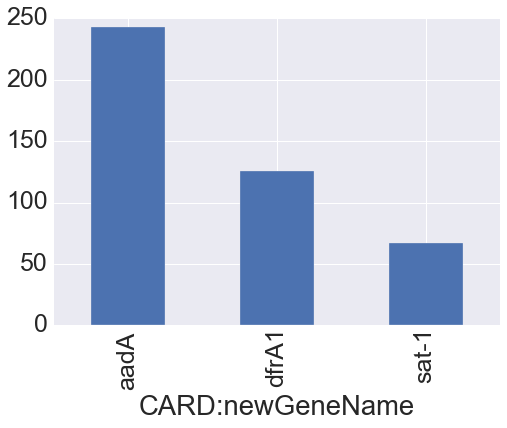

In [86]:
dfMIp3[(dfMIp3.MinIONPlate=='F4')&(dfMIp3['CARD:pident']>80)&(dfMIp3['CARD:coverageOfSubjectGene']>50)].groupby('CARD:newGeneName').size().plot(kind='bar')

In [87]:
dfMIp3[(dfMIp3.MinIONPlate=='F4')&(dfMIp3['CARD:pident']>80)&(dfMIp3['CARD:coverageOfSubjectGene']>50)].groupby('CARD:qseqid').count().shape[0]

244

However _dfrA1_ and _sat-1_ are also found, although these genes are not known to confer resistance to spectinomycin

In [88]:
#As an example I took plate F4 since it was cultured only on spc. We can see that there are four unique abxs in there
#In order to say something sensable. ie can sat-1 confer resistance on its own? We need to plot the combinatorial occurance
#The next lines will calculate the different combinatorial modes in which the abx occur. There must be a much smarter way of doing this
#but for now this does the job. Note that it only works for a combination of 1 or 2 abx.

dfCombine = pd.DataFrame()

#Read in the unique abx in this specific plate
uniqueAbx = dfMIp3[(dfMIp3.MinIONPlate=='F4')&(dfMIp3['CARD:pident']>80)&(dfMIp3['CARD:coverageOfSubjectGene']>45)]['CARD:newGeneName'].unique()
keeper = []
totalSet = set() #keep track of the progress

dfrA = [] #track list of interest
sat = []
check = 0
for first in uniqueAbx:
    for second in uniqueAbx:
        if frozenset([first,second]) in totalSet: #If this combination (first,second) or (second,first) already excist, just skip
            continue
        totalSet.add(frozenset([first,second])) #Add this combination to the visit list
    
    
        print first,second
        counter = 0
        for name, group in dfMIp3[(dfMIp3.MinIONPlate=='F4')&(dfMIp3['CARD:pident']>80)&(dfMIp3['CARD:coverageOfSubjectGene']>45)].groupby(['CARD:qseqid']):
            if (first in((group['CARD:newGeneName'].tolist()))) & (second in((group['CARD:newGeneName'].tolist()))):
                if first == second: #Make an expection for first == second, I interpret this as intersted in only 1 abx
                    if len(group['CARD:newGeneName'].tolist())==1: #however this means ONLY 1 and not 2 abx should be present on this rread
                        counter = counter +1
                        if group['CARD:newGeneName'].tolist()[0]=='aadA':
                            keeper.append(name)
                else: # first !=second, so just count
                    counter = counter +1
                    if ((first=='aadA') & (second=='dfrA1')) | ((second=='aadA') & (first=='dfrA1')) : 
                        dfrA.append(name)
                    if ((first=='aadA') & (second=='sat-1')) | ((second=='aadA') & (first=='sat-1')) : 
                        sat.append(name)
                       

        #Following lines make a tiny dfCombine frame that can be plotted
        if counter>0:
            if first == second:
                dfCombine = dfCombine.append({'abx':[first],'readcount':counter},ignore_index=True)
            else:
                dfCombine = dfCombine.append({'abx':[first,second],'readcount':counter},ignore_index=True)
                
        print counter
        




aadA aadA
47
aadA dfrA1
126
aadA sat-1
71
dfrA1 dfrA1
0
dfrA1 sat-1
0
sat-1 sat-1
0


This co-occurence list shows that aadA + sat-1 and aadA + dfrA1 are commonly found together

Example of CARD genes found in the nanopore dataset that were plated on spectinomycin. Of the readcount    244.0
dtype: float64 nanopore reads that were recovered on spectinomycin, all contain the aadA which is an aminoglycoside nucleotidyltransferase known to confer resisitance to spectinomycin. 


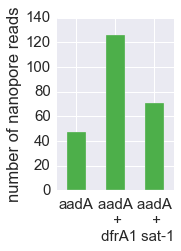

In [89]:

pp = PdfPages('figures/Fig06a_SpecExample.v2.pdf')
sns.set(font_scale=1.5)

try: #pandas does not like setting and index that is already an index, so catch this otherwise still raise the error
    dfCombine = dfCombine.set_index('abx')
except KeyError as e:
    if str(e) == '\'abx\'':
        pass
    else:
        raise KeyError(e)
    
fig, ax = plt.subplots(figsize=(2.5,4))
ax = dfCombine.plot(kind='bar',ax=ax,color=colorSet['MI'])
ax.set_ylabel('number of nanopore reads')
ax.set_xlabel('')



labels = ax.get_xticklabels()
newLabels = []
for thisLabel in labels:
    #We want to align aadA at the left so we need to do a bit a swaping around
    #print str(thisLabel.get_text())

  
    tmp = thisLabel.get_text().replace('[','').replace(']','').split(',') #First remove the [ ] and split on , (we could also just evaluate the string as list)
    if len(tmp)>1: #More then 1 gene in label
        newLabels.append(tmp[0] + " \n + \n" + tmp[1] ) #here do the swapping first 1 then 0!
    else:
        newLabels.append(tmp[0]) #when there is only 1 there is nothing to swap
    
ax.set_xticklabels(newLabels, rotation='horizontal')
ax.legend_.remove()
#ax.set_xscale('log')
plt.gcf().subplots_adjust(left=0.25,bottom=0.3)
pp.savefig()
pp.close()
print "Example of CARD genes found in the nanopore dataset that were plated on spectinomycin. Of the %s nanopore reads that were recovered on spectinomycin, all contain the aadA which is an aminoglycoside nucleotidyltransferase known to confer resisitance to spectinomycin. "  % (dfCombine.sum())
#print "In %s reads aadA is flanked by %s which conferes resistance to trimethoprim and " % (dfCombine.ix[2]['readcount'],dfCombine.ix[2].name)
#print "in %s reads aadA is flanked by %s which confers resistance to streptothricin" % (dfCombine.ix[1]['readcount'],dfCombine.ix[1].name)

Take a closer look at the dfrA and aadA layout. As an examle will take the longest nanopore read that contains the dfrA1 and aadA in the F4 plate.

In [90]:
print 'aadA and dfrA'
handle = open('output/aadA_and_dfrA.fasta', 'w+')

maxLen = 0
maxRecord = None
for record in SeqIO.parse(qPathOrdered['MI_corr2'], "fasta"): 
    
    if  record.id in dfrA:
        #Dirty own fasta writer
        print >>handle, '>' + record.id 
        print >>handle,  record.seq
        if len(record) > maxLen:
            maxLen = len(record)
            maxRecord = record

handle.close()

print maxRecord.description
print maxRecord.seq

aadA and dfrA
BC_19_7 n_reads=3
ATCAGTGATAGAGATACTGAGCACATCAGCAGGACGCACTGACCGAATTTCATTAAAGAGGAGAAAGGTACCGGGCCCCCCTCGAGGTCTGTTGGTTGGACGCAAGACTTTGAATCAATGGGAGCATTACCCAACCGAAAGTATGCGGTCGTAACACGTTCAAGTTTACATCTGACAATGAGAACGTAGTGATCTTTCATCATCAATTAAAGATGCTTTAACCAACCTAAAGAAAATAACGGATCATGTCATTGTTTCAGGTGGTGGGAGAGATATACAAAAGCCTGATCGATCAAGTAGATACACTACATATATCTACAATAGACATCGAGCCGGAAGGTGATGTTTTACTTTCCTGAAATCCCCAGCAATTTTAGCCAGTTTTACCCAAGACTTCGCCTCTAACATAAATTATAGTTACCAAATCTGGCAAAGGGTTAAAGATCCCGGCAGAGAAGCAACGAATTCGCAAACCTGTGCTACGCCTTTGTACCAAAAGCCGCGCCAGGTTTGCGATCCGCTGTGCCAGGCGTTAAACATCATGAGGGAAAGCGGTGATCGCCGAAGTATCGACTCAACTATCAGAGGTAGTTGGCGTCATCGAGCGCCATCTCGAACCGACGTTGTTGCCTGGCCGTACATTTGTACGGCTCCGCAGTGGATGGCGGCCTGAAGCCACACAGTGATATTGATTTGCTGGTTACGGTGACCGTAAGGCTTGATGAAACAACGCGGCGAGCTTTGATCAACGACCTTTGGAAACTTCGGCTTCCCCTGGAGAGAGCGAGATTCTCCGCGCTGTAGAAGTCACCATTGTTGTGCACGACGACATCATTCCGTGGCGTTATCCAGCTAAGCGCGAACTGCAATTTGGAGAGAATGGCAGCGCAATGACATTCTTGCAGGTATCTTCGAGCCAGCCACGATCGACATTGATCTGCGCTATCTTGCTGACAAAAGCAAGAGAA

The read can easily BLASTed using the blastn at NCBI to see what is actually going on an what a potential source is.
The corrected  nanopore read shares 99% sequence identify with the two top scoring hits in the NT database: (light gray) the class I integron from Salmonella enterica subsp. enterica serovar (genbank: HQ132378.1) and the E. coli plasmid pH1038-142 (genbank: KJ484634) described by Wang et al.[25]. IntI denotes integron class I, IS440 an transposon, dfrA encodes a dihydrofolate reductase known to confer resistance against trimethoprim and aadA is an aminoglycoside nucleotidyltransferase known to confer resistance to spectinomycin

In [91]:
#print len(dfPB['CARD:qseqid'].unique())/float(getRecordSize(qPathOrdered['PB_ass']))
print "%0.1f %% of the sequence data contained no hit to the CARD database, which is comparable with other human functional resistome studies " % (100*(1-len(dfMIp3[dfMIp3['CARD:coverageOfSubjectGene']>50]['CARD:qseqid'].unique())/float(getRecordSize(qPathOrdered['MI_polishNoFilter']))))

33.8 % of the sequence data contained no hit to the CARD database, which is comparable with other human functional resistome studies 


## Sup table 7,  barcode overview
Distribution of barcodes over the 5 libraries (horizontal axis) and 7 anitbiotics (horizontal axis) used.

In [94]:
import re

def parseSangerName(lister):
    """
    Here we parse Lejla here Sanger file names, they are not completly logcally named so we need to regex matchers to fish them out
    In the end we still dont know where the plates C1-C6 come from so we need to look that up in the txt files
    Note: EvdH0107 We only use the abx and timepoint information, the plate we will deduce from the 13 files, see below
    """
    tmpList = []
    for thisSeq in lister:

        p = re.compile(ur'([A-H]\d{1,2})_(d2|d4|d5|f1|f2|f3|f4)_120-([1-5])-(amp|cft|tob|spc|azy|mer|tet|fos|chl|cip|mer)')
        regex = re.findall(p, thisSeq)
        if regex:
            a=1
            #print regex
            well = regex[0][0]
            plate = regex[0][1].lower()
            timepoint = regex[0][2]
            abx = regex[0][3]

        else:
            p2 = re.compile(ur'([A-H]\d{1,2})_120-([1-5])-(amp|cft|tob|spc|azy|mer|tet|fos|chl|cip|mer)')
            regex2 = re.findall(p2, thisSeq)
            if regex2:
                #print regex2
                well = regex2[0][0]
                plate = None
                timepoint = regex2[0][1]
                abx = regex2[0][2]

            else:
                well = None
                plate = None
                timepoint = None
                abx = None

                
                print "Cannot asssign: " + thisSeq
        tmpList.append([well,plate,timepoint,abx])
        #print [well,plate,timepoint,abx,direction]
    return tmpList

SangerPlates = ['C1','C2','C3','C4','C5','C6','D2','D4','D5','F1','F2','F3','F4'] #Define the 96 well plates

dfSanger = pd.DataFrame()

for thisPlate in SangerPlates: #Go through each 96 well plate
    with open('inputFiles/expData/samplepooling/' + thisPlate + '.txt' ) as f:
        lines = f.read().splitlines()

    for thisLine in lines:
        dfSanger = dfSanger.append({'SangerFilename':thisLine,'SangerPlate':thisPlate.lower()},ignore_index=True)
        
#Parse the sanger file names
dfSanger['SangerWell'], dfSanger['SangerPlate2'],dfSanger['SangerTimepoint'],dfSanger['SangerAbx'] = zip(*parseSangerName(dfSanger.SangerFilename.tolist()))

dfConvert = pd.read_csv('inputFiles/expData/LI6 AdapterList.txt',delimiter='\t') #Lejla stored the plates and corresponding pacbio adapters here
dfConvert.rename(columns={'Adapter': 'MinIONBarcode', 'Sample': 'SangerPlate'}, inplace=True)
dfConvert.SangerPlate = dfConvert.SangerPlate.str.lower()
dfMerge = pd.merge(dfSanger, dfConvert, how='left', on=['SangerPlate']) #Merge barcodes and plates

dfBC2 = pd.DataFrame()
for thisAbx in dfMerge.SangerAbx.unique():
    for thisTp in dfMerge[dfMerge.SangerAbx==thisAbx].SangerTimepoint.unique():
        #print thisAbx,
        #print thisTp
        results =  sorted(dfMerge[(dfMerge.SangerAbx==thisAbx)&(dfMerge.SangerTimepoint==thisTp)].MinIONBarcode.unique().tolist())
        results = list(map(str, results))
        setter = ' '.join(results)
        #print setter
        dfBC2.set_value(thisTp,thisAbx,setter)
dfBC2 = dfBC2.drop('chl',1) #Drop Chl, not in the mix
dfBC2.columns = dfBC2.columns.str.upper() # amp -> AMP etc
dfBC2 = dfBC2.sort_index(axis=1) #Sort abx 
dfBC2['sample'] = ['120A','120B','120C','120D','120E'] #rename the library name
dfBC2.set_index('sample',inplace=True) #Set the library name as index
dfBC2.sort_index().T.to_csv('figures/SupTable7_BarcodeList.csv')
dfBC2

Cannot asssign: A01_f1_165A-spc
Cannot asssign: B01_f1_165A-spc
Cannot asssign: C01_f1_165A-spc
Cannot asssign: D01_f1_165D-spc


,AMP,AZY,CFT,FOS,SPC,TET,TOB
sample,,,,,,,
120A,1 18 23 31 36 44,1 18 23 31 36 44,1 23 36,21 34 47,16 19 29 32 42 45,1 23 36,1 23 36
120B,1 11 18 23 24 31 36 37 44,11 18 24 31 37 44,11 24 37,21 22 34 35 47 48,16 19 29 32 42 45,12 25 38,11 18 24 31 37 44
120C,12 18 25 31 38 44,12 13 25 26 38 39,12 25 38,22 35 48,16 19 29 32 42 45,13 26 39,12 18 25 31 38 44
120D,13 26 39,14 18 27 31 40 44,13 26 39,20 33 46,16 19 29 32 42 45,14 27 40,13 14 18 26 27 31 39 40 44
120E,14 17 27 30 40 43,15 18 28 31 41 44,14 15 17 27 28 30 40 41 43,22 35 48,17 19 30 32 43 45,15 17 28 30 41 43,15 18 28 31 41 44
